# Process raw data

In [2]:
import pandas as pd
import numpy as np
import jieba

CommentsAll是新的数据  
CommentsType中前500条是好评，中间500条是中评，最后500条是差评；500条好评和500条差评中除去和CommentsAll重复的评论是拿来训练的语料

In [3]:
CommentsAll = pd.read_pickle('HotComments_all.pkl')
CommentsType = pd.read_pickle('HotComments_byType.pkl')

In [25]:
# generate two files of positive and negative comments
def getPosNeg(A=CommentsAll, T=CommentsType):
    pos = []
    neg = []
    for film in T:
        pos1film = list(T[film]['Comment'][:500])
        neg1film = list(T[film]['Comment'][1000:])
        for i in range(len(pos1film)):
            if pos1film[i] not in list(A[film]['Comment']):
                pos.append(pos1film[i])
            if neg1film[i] not in list(A[film]['Comment']):
                neg.append(neg1film[i])
    
    pos_data = pd.DataFrame({'Comment':pos})
    neg_data = pd.DataFrame({'Comment':neg})
    pos_data.to_excel('svm_data/pos.xlsx', header=False, index=False)
    neg_data.to_excel('svm_data/neg.xlsx', header=False, index=False)
    
    return pos_data, neg_data

In [27]:
pos, neg = getPosNeg()

# Train Word2Vec model

In [29]:
from sklearn.model_selection import train_test_split
from gensim.models.word2vec import Word2Vec  #构造词向量

## Generate the training set and the test set

In [165]:
jieba.load_userdict('corpus/mydict-sougou.txt')

In [166]:
stopwords = open('corpus/HGDstopwords.txt', 'r+', encoding='utf-8')
mySW = stopwords.read().split("\n")
mySW = [word.strip() for word in mySW]
len(mySW)

768

In [50]:
# function for word tokenization
def cutWords(comment, stopwords=mySW):
    myWords = []
    words = list(jieba.cut(comment))
    for word in words:
        if word not in stopwords:
            myWords.append(word)
    
    return myWords

In [54]:
# tokenize words of the positive and negative comments, train test split
def getTrainData(pos, neg):
    pos['words'] = pos['Comment'].apply(cutWords)      #执行分词，了解apply的价值作用
    neg['words'] = neg['Comment'].apply(cutWords)

    #use 1 for positive (正面，积极的) sentiment, 0 for negative (负面，消极的)
    y = np.concatenate((np.ones(len(pos)), np.zeros(len(neg)))) #构造标记值y,由concatenate合并正、负语料数得到

    x_train, x_test, y_train, y_test = train_test_split(np.concatenate((pos['words'], neg['words'])), y, 
                                                        test_size=0.2, random_state=3)
    
    np.save('svm_data/y_train.npy',y_train)   #将训练标记存储起来，以备后用
    np.save('svm_data/y_test.npy',y_test)     #将测试标记存储起来，以备后用
    return x_train,x_test      #返回训练集和测试集数据

In [57]:
x_train,x_test = getTrainData(pos, neg)

In [58]:
print(x_train[0])
print(x_train[0][0])

['合家欢', '父母', '子女', '情', '很', '懂', '市场', '节令', '小妖', '王萌到', '心软']
合家欢


## Train Word2Vec

In [61]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [95]:
#对每个句子的所有词向量取均值
def buildWordVector(text, size, my_w2v):
    #text：一条文本，size一个词向量维度，my_w2v训练好的词向量
    vec = np.zeros(size).reshape((1, size)) #初始一个1行size列的向量
    count = 0.
    for word in text:
        try:
            vec += my_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count  #求均值
    return vec

In [96]:
n_dim = 300
#初始化词向量模型和构建词汇表
my_w2v = Word2Vec(vector_size=n_dim, window=5, min_count=5, sg=1)  #size特征向量的维数，min_count小于该词频数单词将被抛弃
my_w2v.build_vocab(x_train)                  #构建词汇表

#在训练集上训练模型（这可能需要几分钟的时间）
my_w2v.train(x_train,total_examples=my_w2v.corpus_count, epochs=my_w2v.epochs)

# get the train_vecs for svm
train_vecs = np.concatenate([buildWordVector(z, n_dim, my_w2v) for z in x_train])
np.save('svm_data/train_vecs.npy',train_vecs)
print(train_vecs.shape)

#Train word2vec on the test set
my_w2v.train(x_test,total_examples=my_w2v.corpus_count, epochs=my_w2v.epochs)
my_w2v.save('svm_data/w2v_model.pkl')

# get the test_vecs for svm
test_vecs = np.concatenate([buildWordVector(z, n_dim,my_w2v) for z in x_test])
np.save('svm_data/test_vecs.npy',test_vecs)
print(test_vecs.shape)

2021-12-20 16:24:45,150 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.025)', 'datetime': '2021-12-20T16:24:45.150275', 'gensim': '4.0.1', 'python': '3.7.4 (default, Aug 13 2019, 15:17:50) \n[Clang 4.0.1 (tags/RELEASE_401/final)]', 'platform': 'Darwin-20.6.0-x86_64-i386-64bit', 'event': 'created'}
2021-12-20 16:24:45,158 : INFO : collecting all words and their counts
2021-12-20 16:24:45,159 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-12-20 16:24:45,239 : INFO : collected 23518 word types from a corpus of 158574 raw words and 7516 sentences
2021-12-20 16:24:45,240 : INFO : Creating a fresh vocabulary
2021-12-20 16:24:45,287 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4344 unique words (18.470958414831195%% of original 23518, drops 19174)', 'datetime': '2021-12-20T16:24:45.287661', 'gensim': '4.0.1', 'python': '3.7.4 (default, Aug 13 2019, 15:17:50) \n[Clang 4.0.1 (tags/RELEASE_401/

(7516, 300)


2021-12-20 16:24:49,743 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-12-20 16:24:49,747 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-12-20 16:24:49,818 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-12-20 16:24:49,819 : INFO : EPOCH - 2 : training on 40263 raw words (28535 effective words) took 0.2s, 128680 effective words/s
2021-12-20 16:24:49,819 : WARNING : EPOCH - 2 : supplied example count (1879) did not equal expected count (7516)
2021-12-20 16:24:50,013 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-12-20 16:24:50,032 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-12-20 16:24:50,099 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-12-20 16:24:50,100 : INFO : EPOCH - 3 : training on 40263 raw words (28572 effective words) took 0.2s, 126094 effective words/s
2021-12-20 16:24:50,100 : WARNING : EPOCH - 3 : supplied example count (18

(1879, 300)


训练好的模型为`my_w2v`  
`train_vecs` 和 `test_vecs` 用于训练之后的svm

## Calculate word similarity

Use the Word2Vec model to calculate word similarity between words in the comments and words of film attributes

In [149]:
chaWords = ['特效','剧情','人物','喜剧','导演','演员','演技'] # words of film attributes
filmYearDict = {
    2016: ['meirenyu', 'xiyouji', 'aomen'],
    2017: ['gongfu', 'xiyoufuyao', 'chengfeng'],
    2018: ['honghai', 'chinatown2', 'zhuoyaoji2'],
    2019: ['liulangdiqiu', 'waixingren', 'feichirensheng'],
    2021: ['lihuanying', 'chinatown3', 'xiaoshuojia']
}

In [101]:
# 对CommentsAll中的15部电影评论进行分词
for film in CommentsAll:
    CommentsAll[film]['words'] = CommentsAll[film]['Comment'].apply(cutWords)

In [121]:
# 对CommentsAll生成每年的corpus（3部电影为一年）
def corpusYear(year):
    film1 = filmYearDict[year][0]
    film2 = filmYearDict[year][1]
    film3 = filmYearDict[year][2]
    corpus = np.concatenate((CommentsAll[film1]['words'], CommentsAll[film2]['words'], CommentsAll[film3]['words']))
    corpus = [word for comment in corpus for word in comment if word not in (' ', '…', '⋯', '\n')]
    
    return corpus

In [124]:
corpusYearDict = dict.fromkeys([2016, 2017, 2018, 2019, 2021])
for year in corpusYearDict:
    corpusYearDict[year] = corpusYear(year)

In [126]:
for year in corpusYearDict: print(len(corpusYearDict[year]))

26940
31451
31830
52158
44635


In [127]:
# 得到每年的高频词，并计算它们与电影特征词之间的相似度，构建电影特征词表
from collections import Counter

corpusYearCountDict = dict.fromkeys([2016,2017,2018,2019,2021])

for year in corpusYearCountDict:
    corpusYearCountDict[year] = Counter(corpusYearDict[year])

In [154]:
def countSimilarity(year, chaWord, mostCommon=2000, threshold=0.7):
    wordsCalculated = [word for word,freq in corpusYearCountDict[year].most_common(mostCommon)]
    
    mostSimilar = []
    for word in wordsCalculated:
        try:
            if my_w2v.wv.similarity(chaWord,word) >= threshold:
                mostSimilar.append(word)
        except KeyError:
            continue
    
    return mostSimilar

In [163]:
def getSimilarity4Cha(year, chaWords=chaWords, mostCommon=2000, threshold=0.7):
    chaWordsDict = dict.fromkeys(chaWords)
    for chaWord in chaWords:
        chaWordsDict[chaWord] = countSimilarity(year, chaWord, mostCommon=mostCommon, threshold=threshold)
    
    myCWdict = pd.concat([pd.DataFrame({chaWord: chaWordsDict[chaWord]}) for chaWord in chaWordsDict], axis=1)
    myCWdict.fillna('')
    
    myCWdict.to_excel('ChaWordsDict_year/CWdict'+str(year)+'.xlsx', index=False)
    return myCWdict

In [164]:
for year in [2016, 2017, 2018, 2019, 2021]:
    getSimilarity4Cha(year)

# Sentiment analysis based on SVM

## Train SVM model

In [179]:
import joblib   #模型持久化
from sklearn.svm import SVC
from sklearn.preprocessing import scale

In [167]:
def get_data():
    train_vecs=np.load('svm_data/train_vecs.npy')
    y_train=np.load('svm_data/y_train.npy')
    test_vecs=np.load('svm_data/test_vecs.npy')
    y_test=np.load('svm_data/y_test.npy') 
    return train_vecs,y_train,test_vecs,y_test

In [180]:
train_vecs,y_train,test_vecs,y_test=get_data()   #导入保存的训练数据和测试数据
train_vecs = scale(train_vecs)
test_vecs = scale(test_vecs)

In [396]:
print(len(train_vecs), len(y_train))
print(sum(y_train))

7516 7516
3981.0


In [397]:
7516-3981

3535

In [181]:
# train svm
def svm_train(train_vecs,y_train,test_vecs,y_test):
    clf=SVC(kernel='rbf',verbose=True)
    clf.fit(train_vecs,y_train)
    joblib.dump(clf, 'svm_data/svm_model.pkl') #保存训练好的模型
    print(clf.score(test_vecs,y_test))    #输出模型评估
    return clf

In [182]:
svm_train(train_vecs,y_train,test_vecs,y_test)   #训练svm并保存模型

[LibSVM]....*.*
optimization finished, #iter = 5162
obj = -4550.304740, rho = -0.073086
nSV = 5075, nBSV = 4654
Total nSV = 5075
0.7243214475784993


SVC(verbose=True)

In [183]:
clf = joblib.load('svm_data/svm_model.pkl')
y_predict = clf.predict(test_vecs)

In [184]:
# performance metrics
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

         0.0       0.70      0.71      0.71       878
         1.0       0.74      0.74      0.74      1001

    accuracy                           0.72      1879
   macro avg       0.72      0.72      0.72      1879
weighted avg       0.72      0.72      0.72      1879



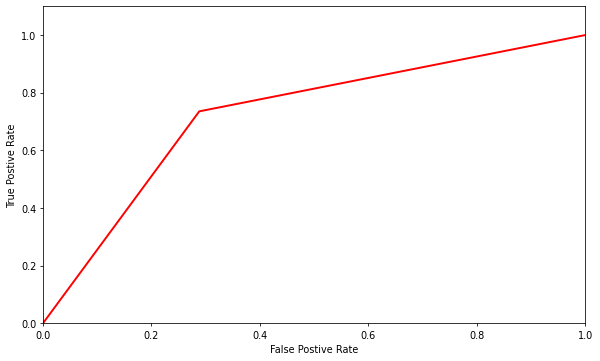

In [187]:
# plot the ROC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

plt.rcParams['savefig.dpi'] = 300 # 图片像素
plt.rcParams['figure.dpi'] = 70 # 分辨率

## 求出ROC曲线的x轴和y轴
fpr, tpr, thresholds = \
roc_curve(y_test,y_predict)
fig = plt.figure(3, (10,6))
plt.xlim(0,1) ##设定x轴的范围
plt.ylim(0.0,1.1) ## 设定y轴的范围
plt.xlabel('False Postive Rate')
plt.ylabel('True Postive Rate')
plt.plot(fpr,tpr,linewidth=2, linestyle="-",color='red')
plt.show()
fig.savefig('figures/svm_roc.png')

In [398]:
# calculate AUC
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(y_test, y_predict, pos_label=1)
auc(fpr, tpr)

0.7235549188852151

## Calculate sentiment polarity of each year's film reviews

In [359]:
# 得到每年的CommentsAll，用一个字典储存
CommentsAll_year = dict.fromkeys(filmYearDict)
for year in CommentsAll_year:
    film1 = filmYearDict[year][0]
    film2 = filmYearDict[year][1]
    film3 = filmYearDict[year][2]
    CommentsAll_year[year] = pd.concat([CommentsAll[film1],CommentsAll[film2],CommentsAll[film3]], 
                                        axis=0, ignore_index=True)

In [ ]:
for year in CommentsAll_year:
    CommentsAll_year[year]['sentiment'] = np.zeros(len(CommentsAll_year[year]))
    
    vecs2predict = np.concatenate([buildWordVector(words, n_dim, my_w2v) for words in CommentsAll_year[year]['words']])
    vecs2predict = scale(vecs2predict)
    
    for i in range(len(CommentsAll_year[year])):
        vec = vecs2predict[i].reshape(1,-1)
        CommentsAll_year[year]['sentiment'].loc[i] = int(clf.predict(vec)[0])

In [361]:
CommentsAll_year[2016].groupby(['sentiment']).size()

sentiment
0.0    665
1.0    835
dtype: int64

In [362]:
CommentsAll_year[2017].groupby(['sentiment']).size()

sentiment
0.0    665
1.0    835
dtype: int64

In [363]:
CommentsAll_year[2018].groupby(['sentiment']).size()

sentiment
0.0    746
1.0    754
dtype: int64

In [364]:
CommentsAll_year[2019].groupby(['sentiment']).size()

sentiment
0.0    682
1.0    818
dtype: int64

In [365]:
CommentsAll_year[2021].groupby(['sentiment']).size()

sentiment
0.0    681
1.0    819
dtype: int64

In [372]:
for year in CommentsAll_year:
    CommentsAll_year[year].to_excel('sentiment/sentiment'+str(year)+'.xlsx', index=False)

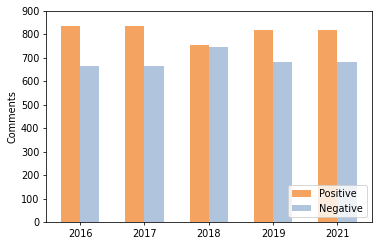

In [389]:
labels = ['2016', '2017', '2018', '2019', '2021']
Positive = [835, 835, 754, 818, 819]
Negative = [665, 665, 746, 682, 681]
 
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars
 
sentiment_bar = plt.figure()
plt.bar(x - width/2, Positive, width, label='Positive', color='sandybrown')
plt.bar(x + width/2, Negative, width, label='Negative', color='lightsteelblue')
 
# Add some text for labels, title and 
# custom x-axis tick labels, etc.
plt.ylabel('Comments')
plt.ylim((0,900))
plt.xticks( np.arange(5), labels )
plt.legend(loc='lower right')
plt.show()
sentiment_bar.savefig('figures/sentiment_bar.png')